In [42]:
import pandas as pd
import os

# Define base data directory
RAW_DATA_DIR = os.path.abspath("../../data/raw")
PROCCESSED_DATA_DIR = os.path.abspath("../../data/processed")

# Load datasets
ndt = pd.read_csv(os.path.join(RAW_DATA_DIR, "ndt.csv"))
print("Non-derivative transactions shape: ", ndt.shape)
assert ndt.shape == (255414, 13)
ndt["MONTH_END"] = pd.to_datetime(ndt["TRANS_DATE"]) + pd.offsets.MonthEnd(0)

# Load datasets
sage_factors = pd.read_csv(os.path.join(PROCCESSED_DATA_DIR, "sage_factors.csv"))
returns = sage_factors[["MONTH_END", "COMPANY_ID", "EXCESS_RETURN_USD_LN"]]
print("Returns shape: ", returns.shape)
assert returns.shape == (120624, 3)

market_cap = pd.read_csv(os.path.join(RAW_DATA_DIR, "market_cap.csv"))
print("market_cap shape: ", market_cap.shape)
assert market_cap.shape == (143295, 3)
market_cap["MONTH_END"] = pd.to_datetime(market_cap["DAY_DATE"]) + pd.offsets.MonthEnd(0)
# multiply by one million
market_cap["MARKET_CAP_USD"] = market_cap["MARKET_CAP_USD"] * 1e6

# Merge datasets
ndt = pd.merge(ndt, market_cap, on=["MONTH_END", "COMPANY_ID"], how="left")

Non-derivative transactions shape:  (255414, 13)
Returns shape:  (120624, 3)
market_cap shape:  (143295, 3)


In [43]:
print(ndt.head(100).to_markdown())

|    | ACCESSION_NUMBER     | TRANS_DATE   | TRANS_CODE   | EQUITY_SWAP_INVOLVED   |   TRANS_SHARES |   TRANS_PRICEPERSHARE | TRANS_ACQUIRED_DISP_CD   |   SHRS_OWND_FOLWNG_TRANS | DIRECT_INDIRECT_OWNERSHIP   |   COMPANY_ID | RPTOWNERNAME                    | RPTOWNER_RELATIONSHIP   | RPTOWNER_TITLE           | MONTH_END           | DAY_DATE   |   MARKET_CAP_USD |
|---:|:---------------------|:-------------|:-------------|:-----------------------|---------------:|----------------------:|:-------------------------|-------------------------:|:----------------------------|-------------:|:--------------------------------|:------------------------|:-------------------------|:--------------------|:-----------|-----------------:|
|  0 | 0001214659-22-008493 | 2022-06-29   | P            | false                  |          10000 |                  0.88 | A                        |              1e+07       | I                           |    367712111 | AULT MILTON C III               | TenPercen

In [44]:
# ndt = ndt[ndt['TRANS_CODE'].isin(['P', 'S'])]
# ndt = ndt[ndt['DIRECT_INDIRECT_OWNERSHIP'].isin(['D'])]
# ndt = ndt.dropna(subset=['RPTOWNER_TITLE'])

In [45]:
print(ndt.head(100).to_markdown())

|    | ACCESSION_NUMBER     | TRANS_DATE   | TRANS_CODE   | EQUITY_SWAP_INVOLVED   |   TRANS_SHARES |   TRANS_PRICEPERSHARE | TRANS_ACQUIRED_DISP_CD   |   SHRS_OWND_FOLWNG_TRANS | DIRECT_INDIRECT_OWNERSHIP   |   COMPANY_ID | RPTOWNERNAME                    | RPTOWNER_RELATIONSHIP   | RPTOWNER_TITLE           | MONTH_END           | DAY_DATE   |   MARKET_CAP_USD |
|---:|:---------------------|:-------------|:-------------|:-----------------------|---------------:|----------------------:|:-------------------------|-------------------------:|:----------------------------|-------------:|:--------------------------------|:------------------------|:-------------------------|:--------------------|:-----------|-----------------:|
|  0 | 0001214659-22-008493 | 2022-06-29   | P            | false                  |          10000 |                  0.88 | A                        |              1e+07       | I                           |    367712111 | AULT MILTON C III               | TenPercen

In [46]:
print(ndt["RPTOWNER_RELATIONSHIP"].value_counts())

RPTOWNER_RELATIONSHIP
Director,Officer                         55000
TenPercentOwner                          49373
Director,TenPercentOwner                 46859
Director                                 35901
Officer                                  30012
Director,Officer,TenPercentOwner         17649
TenPercentOwnerOther                     12428
Other                                     5364
DirectorOther                             1498
Director,TenPercentOwnerOther              509
Director,OfficerOther                      313
Officer,TenPercentOwner                    202
OfficerOther                               191
Director,Other                              66
Director,TenPercentOwner,Other              47
TenPercentOwner,Other                        1
Director,Officer,TenPercentOwnerOther        1
Name: count, dtype: int64


In [47]:
print(ndt["RPTOWNER_TITLE"].unique())

[nan 'Chief Scientific Officer' 'CHIEF OPERATING OFFICER' 'SEE REMARKS'
 'See Remarks' 'President and CEO' 'Global Head of R&D'
 'EVP, Chief Legal Officer' 'Chief Executive Officer' 'President'
 'EXECUTIVE CHAIRMAN' 'President, COO & GM China' 'Chief Legal Officer'
 'CEO & President' 'Chief Medical Officer' 'General Counsel' 'CFO'
 'Chief Financial Officer' 'Executive Chairman' 'CMO'
 'CEO and Chairman of the Board' 'Chairman & CEO' 'Chairman and CEO'
 'President and COO' 'President & CEO' 'Interim CEO'
 'EVP & General Counsel' 'EVP Corp Admin Center' 'CEO'
 'CHIEF EXECUTIVE OFFICER' 'President and Chief Executive'
 'Chief Development Officer' 'CEO and Chairman' 'Executive Chairwoman'
 'Chairman, President and CEO' 'CHAIRPERSON & CEO' 'EVP Commercial'
 'Chief Scientist' 'EVP, Commercial' 'Chief Technical Officer'
 'CEO and President' 'CEO & CHAIRMAN' 'President, CEO and Director'
 'VP, Research' 'CEO & Chief Scientific Officer' 'Chief Operating Officer'
 'Chief Business Officer' 'EVP, 

In [48]:
print(ndt["TRANS_ACQUIRED_DISP_CD"].value_counts())

TRANS_ACQUIRED_DISP_CD
A    132821
D    122593
Name: count, dtype: int64


In [49]:
import pandas as pd
import numpy as np

# Convert TRANS_DATE to datetime and sort the dataframe by COMPANY_ID then TRANS_DATE.
ndt['TRANS_DATE'] = pd.to_datetime(ndt['TRANS_DATE'])
ndt = ndt.sort_values(['COMPANY_ID', 'TRANS_DATE'])

# Create a year_month column for monthly grouping.
ndt['year_month'] = ndt['TRANS_DATE'].dt.to_period('M')

# Calculate net_TRANS_SHARES for each row:
# "A" (acquired) adds TRANS_SHARES; "D" (disposed) subtracts TRANS_SHARES.
ndt['net_TRANS_SHARES'] = np.where(
    ndt['TRANS_ACQUIRED_DISP_CD'] == 'A',
    ndt['TRANS_SHARES'],
    np.where(ndt['TRANS_ACQUIRED_DISP_CD'] == 'D', -ndt['TRANS_SHARES'], 0)
)

# Group by COMPANY_ID and year_month, summing net transaction shares
# and taking the mean of holdings to get the average value for the month.
monthly = ndt.groupby(['COMPANY_ID', 'year_month']).agg(
    total_net_TRANS_SHARES=('net_TRANS_SHARES', 'sum'),
    avg_SHRS_OWND_FOLWNG_TRANS=('SHRS_OWND_FOLWNG_TRANS', 'mean')
).reset_index()

# Calculate monthly score, ensuring no division by zero.
monthly['monthly_score'] = monthly.apply(
    lambda row: row['total_net_TRANS_SHARES'] / row['avg_SHRS_OWND_FOLWNG_TRANS'] if row['avg_SHRS_OWND_FOLWNG_TRANS'] != 0 else 0,
    axis=1
)

print(monthly.head(100).to_markdown())

|    |   COMPANY_ID | year_month   |   total_net_TRANS_SHARES |   avg_SHRS_OWND_FOLWNG_TRANS |   monthly_score |
|---:|-------------:|:-------------|-------------------------:|-----------------------------:|----------------:|
|  0 |        24153 | 2007-11      |          10000           |               5500           |      1.81818    |
|  1 |        24153 | 2012-01      |         -40000           |                850           |    -47.0588     |
|  2 |        24153 | 2020-04      |           1750           |                 40           |     43.75       |
|  3 |        24165 | 2006-03      |         217600           |               2085           |    104.365      |
|  4 |        24246 | 2007-02      |          -7500           |               1630           |     -4.60123    |
|  5 |        24246 | 2007-06      |        -143708           |               1630           |    -88.1644     |
|  6 |        24246 | 2008-02      |        -100000           |               1630           |  

In [50]:
# Group by COMPANY_ID and year_month, summing net transaction shares,
# and taking the mean of holdings and market cap to get monthly averages.
monthly = ndt.groupby(['COMPANY_ID', 'year_month']).agg(
    total_net_TRANS_SHARES=('net_TRANS_SHARES', 'sum'),
    avg_SHRS_OWND_FOLWNG_TRANS=('SHRS_OWND_FOLWNG_TRANS', 'mean'),
    avg_market_cap=('MARKET_CAP_USD', 'mean')
).reset_index()

# Calculate monthly score as before, ensuring no division by zero.
monthly['monthly_score'] = monthly.apply(
    lambda row: row['total_net_TRANS_SHARES'] / row['avg_SHRS_OWND_FOLWNG_TRANS'] if row['avg_SHRS_OWND_FOLWNG_TRANS'] != 0 else 0,
    axis=1
)

# Create a new column: market_cap_adjusted_score.
# This metric shows net insider transactions relative to both insider holdings and company size.
monthly['market_cap_adjusted_score'] = monthly.apply(
    lambda row: row['monthly_score'] / row['avg_market_cap'] if row['avg_market_cap'] != 0 else 0,
    axis=1
)

print(monthly.head(100).to_markdown())

|    |   COMPANY_ID | year_month   |   total_net_TRANS_SHARES |   avg_SHRS_OWND_FOLWNG_TRANS |   avg_market_cap |   monthly_score |   market_cap_adjusted_score |
|---:|-------------:|:-------------|-------------------------:|-----------------------------:|-----------------:|----------------:|----------------------------:|
|  0 |        24153 | 2007-11      |          10000           |               5500           |      1.07475e+08 |      1.81818    |                 1.69172e-08 |
|  1 |        24153 | 2012-01      |         -40000           |                850           |      7.76568e+07 |    -47.0588     |                -6.05985e-07 |
|  2 |        24153 | 2020-04      |           1750           |                 40           |      6.54413e+08 |     43.75       |                 6.68539e-08 |
|  3 |        24165 | 2006-03      |         217600           |               2085           |      2.06778e+09 |    104.365      |                 5.04718e-08 |
|  4 |        24246 | 2007-0

In [51]:
print(monthly.shape)

(14298, 7)


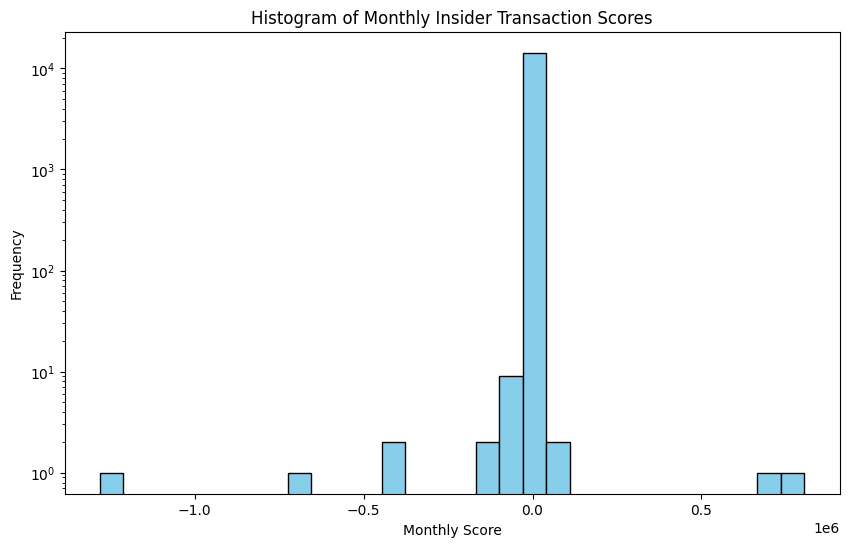

In [52]:
import matplotlib.pyplot as plt

# Plot a histogram of the monthly_score
plt.figure(figsize=(10, 6))
plt.hist(monthly['monthly_score'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Monthly Score')
plt.yscale('log')
plt.ylabel('Frequency')
plt.title('Histogram of Monthly Insider Transaction Scores')
plt.show()

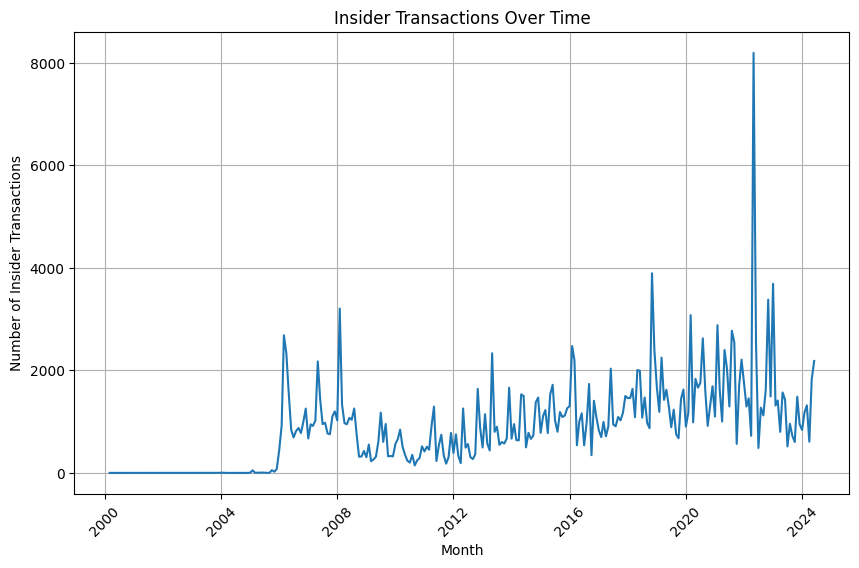

In [53]:
# Group by year_month and count the number of transactions in each month.
transactions_over_time = ndt.groupby('year_month').size().reset_index(name='transaction_count')

# Convert year_month to a timestamp for plotting (beginning of each month).
transactions_over_time['month_start'] = transactions_over_time['year_month'].dt.to_timestamp()

# Plot the number of insider transactions over time.
plt.figure(figsize=(10, 6))
plt.plot(transactions_over_time['month_start'], transactions_over_time['transaction_count'])
plt.xlabel('Month')
plt.ylabel('Number of Insider Transactions')
plt.title('Insider Transactions Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [54]:
# Assuming 'monthly' is our dataframe with 'monthly_score' already calculated

# Create the naive_monthly_score column:
monthly['naive_monthly_score'] = np.where(
    monthly['monthly_score'] > 0, 1,
    np.where(monthly['monthly_score'] < 0, -1, 0)
)

# Convert "year_month" to the last day of each month.
# If "year_month" is a period (e.g., Period('2022-06', 'M')), converting it to a timestamp with 'M'
# returns the last calendar day of that month.
monthly['year_month'] = pd.to_datetime(monthly['year_month'].astype(str)) + pd.offsets.MonthEnd(0)

# Optionally, print the updated dataframe to verify the conversion.
print(monthly.head(100).to_markdown())

|    |   COMPANY_ID | year_month          |   total_net_TRANS_SHARES |   avg_SHRS_OWND_FOLWNG_TRANS |   avg_market_cap |   monthly_score |   market_cap_adjusted_score |   naive_monthly_score |
|---:|-------------:|:--------------------|-------------------------:|-----------------------------:|-----------------:|----------------:|----------------------------:|----------------------:|
|  0 |        24153 | 2007-11-30 00:00:00 |          10000           |               5500           |      1.07475e+08 |      1.81818    |                 1.69172e-08 |                     1 |
|  1 |        24153 | 2012-01-31 00:00:00 |         -40000           |                850           |      7.76568e+07 |    -47.0588     |                -6.05985e-07 |                    -1 |
|  2 |        24153 | 2020-04-30 00:00:00 |           1750           |                 40           |      6.54413e+08 |     43.75       |                 6.68539e-08 |                     1 |
|  3 |        24165 | 2006-03-31 00

In [55]:
print(returns.head(100).to_markdown())

|    | MONTH_END   |   COMPANY_ID |   EXCESS_RETURN_USD_LN |
|---:|:------------|-------------:|-----------------------:|
|  0 | 1997-02-28  |        21727 |           -0.078885    |
|  1 | 1997-03-31  |        21727 |            0.0326605   |
|  2 | 1997-04-30  |        21727 |            0.00976175  |
|  3 | 1997-05-31  |        21727 |            0.0940927   |
|  4 | 1997-06-30  |        21727 |            0.0128094   |
|  5 | 1997-07-31  |        21727 |           -0.068543    |
|  6 | 1997-08-31  |        21727 |            0.0841637   |
|  7 | 1997-09-30  |        21727 |            0.00855818  |
|  8 | 1997-10-31  |        21727 |           -0.0494848   |
|  9 | 1997-11-30  |        21727 |            0.0391807   |
| 10 | 1997-12-31  |        21727 |           -0.0530722   |
| 11 | 1998-01-31  |        21727 |           -0.0137433   |
| 12 | 1998-02-28  |        21727 |           -0.0633257   |
| 13 | 1998-03-31  |        21727 |           -0.00631965  |
| 14 | 1998-04-30  |    

In [56]:
returns["year_month"] = pd.to_datetime(returns["MONTH_END"]) + pd.offsets.MonthEnd(0)

/var/folders/d2/h05xc7x1181fd8jxpltdv9v40000gn/T/ipykernel_41544/811911940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns["year_month"] = pd.to_datetime(returns["MONTH_END"]) + pd.offsets.MonthEnd(0)


In [57]:
filtered_ndt_sentiment = pd.merge(returns, monthly, on=['COMPANY_ID', 'year_month'], how='left')

In [59]:
# Merge the 'returns' and 'monthly' dataframes on 'COMPANY_ID' and 'year_month'
filtered_ndt_sentiment = pd.merge(returns, monthly, on=['COMPANY_ID', 'year_month'], how='left')

# Identify the columns coming from 'monthly' that should be set to 0 if missing.
# Update the list below based on the actual monthly columns you want to fill.
monthly_columns = ['total_net_TRANS_SHARES', 'avg_SHRS_OWND_FOLWNG_TRANS', 'monthly_score', "market_cap_adjusted_score"]

# Fill missing monthly values with 0
filtered_ndt_sentiment[monthly_columns] = filtered_ndt_sentiment[monthly_columns].fillna(0)

print(filtered_ndt_sentiment.head().to_markdown())


|    | MONTH_END   |   COMPANY_ID |   EXCESS_RETURN_USD_LN | year_month          |   total_net_TRANS_SHARES |   avg_SHRS_OWND_FOLWNG_TRANS |   avg_market_cap |   monthly_score |   market_cap_adjusted_score |   naive_monthly_score |
|---:|:------------|-------------:|-----------------------:|:--------------------|-------------------------:|-----------------------------:|-----------------:|----------------:|----------------------------:|----------------------:|
|  0 | 1997-02-28  |        21727 |            -0.078885   | 1997-02-28 00:00:00 |                        0 |                            0 |              nan |               0 |                           0 |                   nan |
|  1 | 1997-03-31  |        21727 |             0.0326605  | 1997-03-31 00:00:00 |                        0 |                            0 |              nan |               0 |                           0 |                   nan |
|  2 | 1997-04-30  |        21727 |             0.00976175 | 1997-04-30 

In [62]:
final_ndt_sentiment = filtered_ndt_sentiment[['MONTH_END', 'COMPANY_ID', 'monthly_score', 'market_cap_adjusted_score']]

In [63]:
final_ndt_sentiment.to_csv(os.path.join(PROCCESSED_DATA_DIR, "final_ndt_sentiment.csv"), index=False)

In [ ]:
# historic one month ahead returns for all companies   
    # return less the market return to take out the market 
# for ever unit/individual 
# for every date/month, all psbl returns 
# when they decided to sell or buy what is the z-score of their decision compared to the distribution -> individual score 
# do these characteristics predict future returns
# score every individual, then deccile them by score do we make higher returns 
# randomly select companies, two control groups 
# this ceo cells every march -> not a signal i.e. unsual compared to holdings, market cap, etc.
# company month end and foward return dataset <- will get 
# how quickly after the date that is in the file is it accessible on the edgar webiste
    # + 15 days 
# 1, 3, 6, 12 month returns out 
# set up the testing framework by compan twhat is the distribution of returns when we know when the individual existed 
# individua ,_ uinit that we are interested in 
# are CEOs or CFOs better at timing the market?
# are the board of directors really bad market timers?
# have insiders gotten better or worse at insider trading? over time?
# all the factors and why they should work